<a href="https://colab.research.google.com/github/JV-zero/Ecommerce-RFV-Clustering/blob/main/Customer_RFV_and_Clustering_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

Primeiramente, iremos instalar as bibliotecas que são relevantes e poderão ser utilizadas ao longo do projeto

In [ ]:
# Iremos usar os comandos pip para instalar algumas bibliotecas no nosso Collab
%pip install kmodes
%pip install plotly
!pip install chardet

In [ ]:
# Com todos os pip's realizados, podemos partir para a instalação das libs conforme as categorias que pertencem

# Data wrangling
import numpy as np
import pandas as pd

# Dataviz
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# Yellowbrick para visualização
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

## -- Machine learning -- ##
# Algoritmos de Clusterização
from sklearn.cluster import KMeans, DBSCAN, MeanShift, AgglomerativeClustering
from kmodes.kmodes import KModes            # clustering categorical data
from kmodes.kprototypes import KPrototypes  # clustering mixed data

# Pré-processamento de dados e métricas
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

# Ferramentas adicionais de clusterização
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import k_means, dbscan, mean_shift, estimate_bandwidth

# Ferramentas extras
import string
from ipywidgets import interact
import chardet

In [ ]:
# Customização de código
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

In [ ]:
# # Para evitar erros ao importarmos os dados vamos utilizar o método abaixo para detectar o enconding do nosso acquivo .csv que carrega nosso dataset
# with open("/content/data.csv", 'rb') as file:
#     print(chardet.detect(file.read()))

In [ ]:
# Agora que temos o encoding do nosso datase podemos transformá-lo em um Pandas DataFrame
df = pd.read_csv('/content/data.csv',sep = ",", encoding ='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# 1. Exploratory Data Analysis (EDA)

In [ ]:
# Agora que temos nosso dataset importado podemos iniciar a análise exploratória dos dados
# Começando pelo básico, veremos se é possível detectar rapidamente dados nulos e descobrir os nomes das nossas colunas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Através do método .info() pudemos detectar que há alguns dados nulos nas colunas de Description e CustomerID.
Esses dados nulos serão abordados na etapa de Pré-processamento de Dados.

Outro ponto importante a se tratar é o tipo de dado das colunas. As mudanças que serão realizadas são:

InvoiceDate será passado para formato de data

CustomerID será passado para object (string)

In [ ]:
# Já podemos fazer a correção dos tipos de dados, para facilitar o EDA
df['CustomerID'] = df['CustomerID'].astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
# Uma correção que podemoos fazer agora também é sobre o número de duplicados, que devem removidos da base para evitar confundir o modelo
df.duplicated().sum()

5268

In [ ]:
#Como nosso código tem 5268 linhas duplicadas, vamos limpá-las
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    536641 non-null  object        
 1   StockCode    536641 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     536641 non-null  int64         
 4   InvoiceDate  536641 non-null  datetime64[ns]
 5   UnitPrice    536641 non-null  float64       
 6   CustomerID   536641 non-null  object        
 7   Country      536641 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 36.8+ MB


In [ ]:
# Em sequência podemos realizar uma rápida análise estatística nas varíaveis não categóricas utilizando método .describe()
df.describe()

,Quantity,UnitPrice
count,536641.000000,536641.000000
mean,9.620029,4.632656
std,219.130156,97.233118
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


Podemos notar que as colunas Quantity e UnitPrice tem valoers mínimos negativos. Como esses dados negativos não são esperados nos valores de quantidade e preço unitário, devemos fazer uma análise com o time de negócios e/ou com o time que criou o dataset para identificar se há algum motivo por trás desses valores.

Como não temos acesso à equipe de negócios ou pelos responsáveis pela base de dados (já verifiquei no Kaggle), a ação será contar quantas linhas tem valores negativos e apagá-los

In [ ]:
# O número de itens com UnitPrice neagtiva é de
len(df[df['UnitPrice']<0])

2

In [ ]:
# Os itens com UnitPrice negativa são:
df[df['UnitPrice']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,nan,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,nan,United Kingdom


Portanto faz sentido apagar essas linhas

In [ ]:
df = df[df['UnitPrice']>=0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 536639 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    536639 non-null  object        
 1   StockCode    536639 non-null  object        
 2   Description  535185 non-null  object        
 3   Quantity     536639 non-null  int64         
 4   InvoiceDate  536639 non-null  datetime64[ns]
 5   UnitPrice    536639 non-null  float64       
 6   CustomerID   536639 non-null  object        
 7   Country      536639 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 36.8+ MB


In [ ]:
# Agora verificarei se há linhas com UNitPrice =0 e se isso faz sentido
print("O número de linhas com Unit Price igual a 0 é de: ",len(df[df['UnitPrice']==0]))
print('')
df[df['UnitPrice']==0]

O número de linhas com Unit Price igual a 0 é de:  2510



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,nan,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,nan,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,nan,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,nan,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,nan,United Kingdom
...,...,...,...,...,...,...,...,...
536981,581234,72817,NaN,27,2011-12-08 10:33:00,0.0,nan,United Kingdom
538504,581406,46000M,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,nan,United Kingdom
538505,581406,46000S,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,nan,United Kingdom
538554,581408,85175,NaN,20,2011-12-08 14:06:00,0.0,nan,United Kingdom


In [ ]:
# Agora verificarei se há linhas com Quantity negativa e se isso faz sentido
print("O número de linhas com Unit Price igual a 0 é de: ",len(df[df['Quantity']<0]))
print('')
df[df['Quantity']<0]

O número de linhas com Unit Price igual a 0 é de:  10587



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [ ]:
# Investigarei um pouco mais os produtos listados com Quantitiy negativa, pois podem ser descontos ou reembolsos
# Primeiramente verificarei quais itens estão correlacionados com esses valores

qte_neg = pd.DataFrame(df[df['Quantity']<0]['Description'])

qte_neg.drop_duplicates(inplace=True)

qte_neg.describe()

,Description
count,2110
unique,2110
top,Discount
freq,1


Como pudemos notar, há 2110 produtos que aparecem em nosso DataFrame com Quantiades negativas, sendo o mais frequente deles o "Discount".

Como esses casos não acrestam ao nosso estudo de Clusterização e podem vir a confundir o modelo, iremos limpá-los da nossa base.2

In [ ]:
df = df[df['Quantity']>=0]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 526052 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    526052 non-null  object        
 1   StockCode    526052 non-null  object        
 2   Description  525460 non-null  object        
 3   Quantity     526052 non-null  int64         
 4   InvoiceDate  526052 non-null  datetime64[ns]
 5   UnitPrice    526052 non-null  float64       
 6   CustomerID   526052 non-null  object        
 7   Country      526052 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 36.1+ MB


Dessa forma temos uma base com quase nenhum valor nulo e com as seguintes estatísticas

In [ ]:
df.describe()

,Quantity,UnitPrice
count,526052.000000,526052.000000
mean,10.730911,3.913818
std,157.592136,36.053205
min,1.000000,0.000000
25%,1.000000,1.250000
50%,4.000000,2.080000
75%,11.000000,4.130000
max,80995.000000,13541.330000


In [ ]:
# Agora verificarei se há linhas com Quantitiy =0 e se isso faz sentido
print("O número de linhas com Unit Price igual a 0 é de: ",len(df[df['Quantity']==0]))
print('')
df[df['Quantity']==0]

O número de linhas com Unit Price igual a 0 é de:  0



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


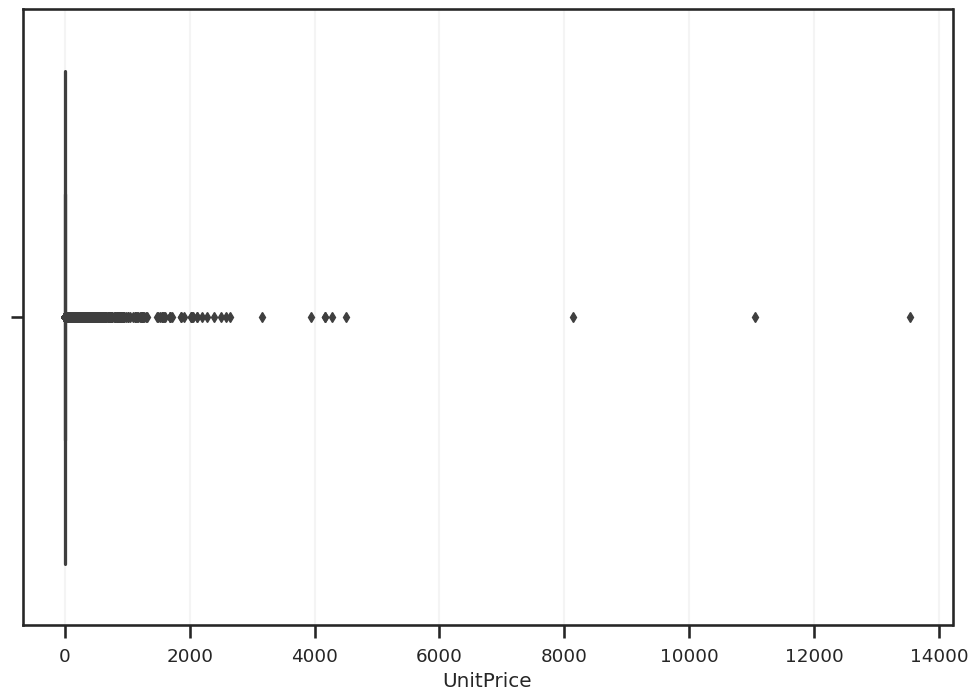

In [ ]:
# Como parte da EDA podemos utilizar os recursos gráficos a nossa disposição para encontrar algumas correlações e extrair insights sobre nosso dataset
# Para começar nossa análise gráfica, faremos as visões de boxplot das nossas variáveis numéricas

# Primeiramente exploraremos a variável UnitPrice e quebraremos ela em categorias, analisando como outras variáveis categóricas se correlacionam com ela

sns.boxplot( x=df["UnitPrice"])
plt.show()

In [ ]:
# Através desse primeiro boxplot podemos notar que a maior parte de nossos dados tem UnitPrice<4000
# Vamos avaliar os casos de UNitPrice acima de 3000 para identificar se eles se encaixam na análise

df[df['UnitPrice']>=3000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
15017,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,nan,United Kingdom
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom
268028,560373,M,Manual,1,2011-07-18 12:30:00,4287.63,nan,United Kingdom
297723,562955,DOT,DOTCOM POSTAGE,1,2011-08-11 10:14:00,4505.17,nan,United Kingdom
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,nan,United Kingdom
374542,569382,M,Manual,1,2011-10-03 16:44:00,3155.95,15502.0,United Kingdom
406406,571751,M,Manual,1,2011-10-19 11:18:00,3949.32,12744.0,Singapore
422351,573077,M,Manual,1,2011-10-27 14:13:00,4161.06,12536.0,France
422376,573080,M,Manual,1,2011-10-27 14:20:00,4161.06,12536.0,France


Os 7 casos de outlier que apresentam UnitPrice maior que 3000 parecem envolver transações específicas (como por exemplo, M é para Manual, B é para Adjust Bad Credit, etc).

Portanto vale investigar os casos em que o stockcode não é um número e sim uma letra, pois não se tratam de compras de clientes reais, mas sim transações do próprio sistema

In [ ]:
# Para isso podemos usar uma expressão regular (REGEX) de forma a encontrarmos os StockCode's usados para transações

list_codes = df[df['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_codes

array(['POST', 'C2', 'DOT', 'M', 'BANK CHARGES', 'AMAZONFEE', 'DCGS0076',
       'DCGS0003', 'gift_0001_40', 'DCGS0070', 'm', 'gift_0001_50',
       'gift_0001_30', 'gift_0001_20', 'DCGS0069', 'DCGSSBOY',
       'DCGSSGIRL', 'gift_0001_10', 'S', 'PADS', 'DCGS0004', 'B'],
      dtype=object)

In [ ]:
# Entre os códigos puxados ainda há alguns que são códigos de produtos reais, como por exemplo o "DCGSSGIRL" que é referente a um item específico
df[df['StockCode']=='DCGSSGIRL'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
84017,543358,DCGSSGIRL,GIRLS PARTY BAG,3,2011-02-07 14:04:00,3.29,nan,United Kingdom
112724,545897,DCGSSGIRL,GIRLS PARTY BAG,5,2011-03-07 17:22:00,3.29,nan,United Kingdom
116892,546306,DCGSSGIRL,GIRLS PARTY BAG,2,2011-03-10 16:16:00,3.29,nan,United Kingdom
128108,547249,DCGSSGIRL,GIRLS PARTY BAG,17,2011-03-22 09:27:00,3.29,nan,United Kingdom
128269,547250,DCGSSGIRL,GIRLS PARTY BAG,2,2011-03-22 09:30:00,3.29,nan,United Kingdom


In [ ]:
# Observando os casos que se destacam entre a lista de códigos que se destacam no REGEX
# é possível notar que os seguintes códigos são referentes a transações:

# POST            -> POSTAGE
# D               -> Discount
# C2              -> CARRIAGE
# M               -> Manual
# BANK CHARGES    -> Bank Charges
# PADS            -> PADS TO MATCH ALL CUSHIONS
# DOT             -> DOTCOM POSTAGE
# B               -> Adjust bad debt
# AMAZONFEE       -> AMAZONFEE
# DOT             -> DOTCOM POSTAGE


# Portanto iremos limpar estes itens de nossa base de dados

codes_dropped = ['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'B', 'AMAZONFEE', 'DOT']

# Filtrar as linhas que NÃO contêm os códigos a serem removidos
df_filtered = df[~df['StockCode'].isin(codes_dropped)]
df_filtered.describe()

,Quantity,UnitPrice
count,523730.000000,523730.000000
mean,10.748874,3.267927
std,157.883535,4.394232
min,1.000000,0.000000
25%,1.000000,1.250000
50%,4.000000,2.080000
75%,12.000000,4.130000
max,80995.000000,649.500000


Como dessa forma nos cortamos diversos casos não úteis à nossa análise de clusterização de clientes, convem refazermos algumas análises estatísticas que havíamos realizado antes

In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523730 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    523730 non-null  object        
 1   StockCode    523730 non-null  object        
 2   Description  523144 non-null  object        
 3   Quantity     523730 non-null  int64         
 4   InvoiceDate  523730 non-null  datetime64[ns]
 5   UnitPrice    523730 non-null  float64       
 6   CustomerID   523730 non-null  object        
 7   Country      523730 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 36.0+ MB


In [ ]:
# Vamos agora explorar as Description's que estão nulas
null_description_df = df.loc[df['Description'].isnull()]
null_description_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,nan,United Kingdom
1970,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,nan,United Kingdom
1971,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,nan,United Kingdom
1972,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,nan,United Kingdom
1987,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,nan,United Kingdom


In [ ]:
# Visualizando as estatisticas dos casos de Description nulo
null_description_df.describe()

,Quantity,UnitPrice
count,592.000000,592.0
mean,54.978041,0.0
std,277.207445,0.0
min,1.000000,0.0
25%,2.000000,0.0
50%,6.000000,0.0
75%,25.250000,0.0
max,5568.000000,0.0


Ao que tudo indica são todos casos de UnitPrice igual a 0 e sem descrição do produto

In [ ]:
# Abaixo verificamos que todos itens que tem Description vazia também tem CustomerID vazio
null_description_df[null_description_df['CustomerID']=='nan'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 592 entries, 622 to 538554
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    592 non-null    object        
 1   StockCode    592 non-null    object        
 2   Description  0 non-null      object        
 3   Quantity     592 non-null    int64         
 4   InvoiceDate  592 non-null    datetime64[ns]
 5   UnitPrice    592 non-null    float64       
 6   CustomerID   592 non-null    object        
 7   Country      592 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 41.6+ KB


In [ ]:
# Como os casos de Description nulo não tem cliente associado, nem UnitPrice, iremos cortá-los de nosso dataframe

df_filtered = df_filtered.dropna(subset=['Description'])
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523144 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    523144 non-null  object        
 1   StockCode    523144 non-null  object        
 2   Description  523144 non-null  object        
 3   Quantity     523144 non-null  int64         
 4   InvoiceDate  523144 non-null  datetime64[ns]
 5   UnitPrice    523144 non-null  float64       
 6   CustomerID   523144 non-null  object        
 7   Country      523144 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 35.9+ MB


In [ ]:
# Ao que tudo indica, agora temos um DataFrame mais preparado para análises gráficas, portanto seguiremos com o boxplot de nossas variáveis
sns.boxplot( x=df_filtered["Quantity"])
plt.show()

In [ ]:
# Dessa maneira tivemos um boxplot muito mais coerente, mas que ainda tem UnitPrices bem mais caros, embora nesse momento, de forma muito mais fiel ao real
# Podemos inclusive confirmar que tais itens não são outliers, mas sim itens caros por si só

df_filtered[df_filtered['UnitPrice']>150]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
246,536392,22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,1,2010-12-01 10:29:00,165.0,13705.0,United Kingdom
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145.0,United Kingdom
19428,537859,22828,REGENCY MIRROR WITH SHUTTERS,1,2010-12-08 16:11:00,165.0,14030.0,United Kingdom
25168,538354,22826,LOVE SEAT ANTIQUE WHITE METAL,2,2010-12-10 15:45:00,175.0,16873.0,United Kingdom
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.0,16607.0,United Kingdom
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.0,17406.0,United Kingdom
54655,540970,22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,1,2011-01-12 13:52:00,165.0,14185.0,United Kingdom
55838,541001,22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,1,2011-01-13 10:28:00,165.0,16500.0,United Kingdom
73447,542349,22827,RUSTIC SEVENTEEN DRAWER SIDEBOARD,1,2011-01-27 12:10:00,165.0,15513.0,United Kingdom
82768,543253,22655,VINTAGE RED KITCHEN CABINET,1,2011-02-04 15:32:00,295.0,14842.0,United Kingdom


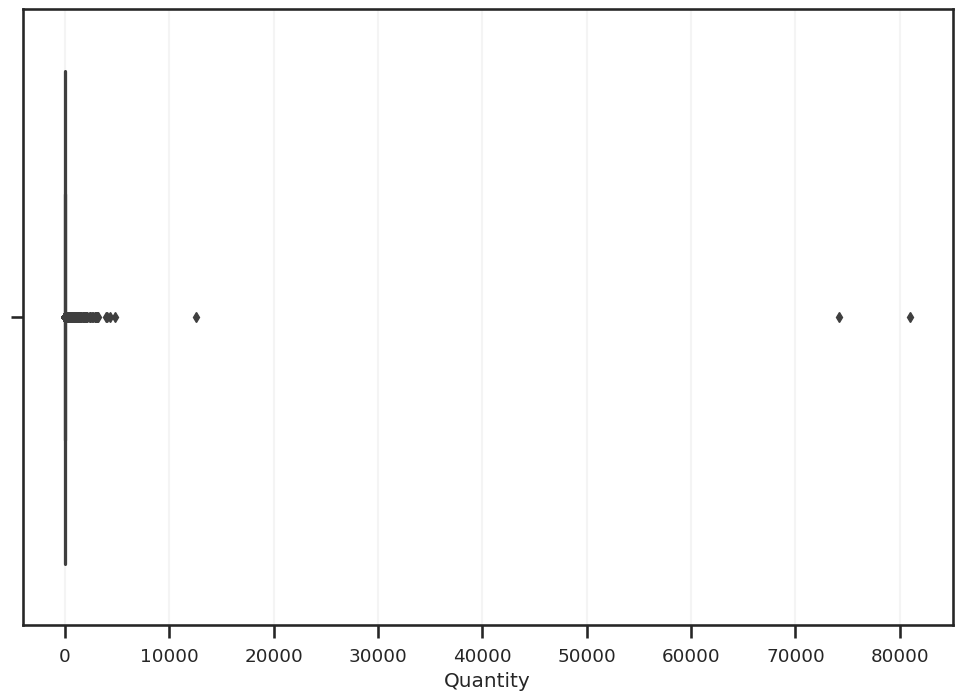

In [ ]:
# Continuando nossa análise gráfica, podemos fazer o Boxplot de outras variáveis

sns.boxplot( x=df_filtered["Quantity"])
plt.show()

In [ ]:
# Como novamente nos deparamos com casos que parecem ser outliers, vamos verificar se tais casos são comportamentos incorretos ou aceitáveis para o dataframe
df_filtered[df_filtered['Quantity']>10000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 523144 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    523144 non-null  object        
 1   StockCode    523144 non-null  object        
 2   Description  523144 non-null  object        
 3   Quantity     523144 non-null  int64         
 4   InvoiceDate  523144 non-null  datetime64[ns]
 5   UnitPrice    523144 non-null  float64       
 6   CustomerID   523144 non-null  object        
 7   Country      523144 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 52.0+ MB


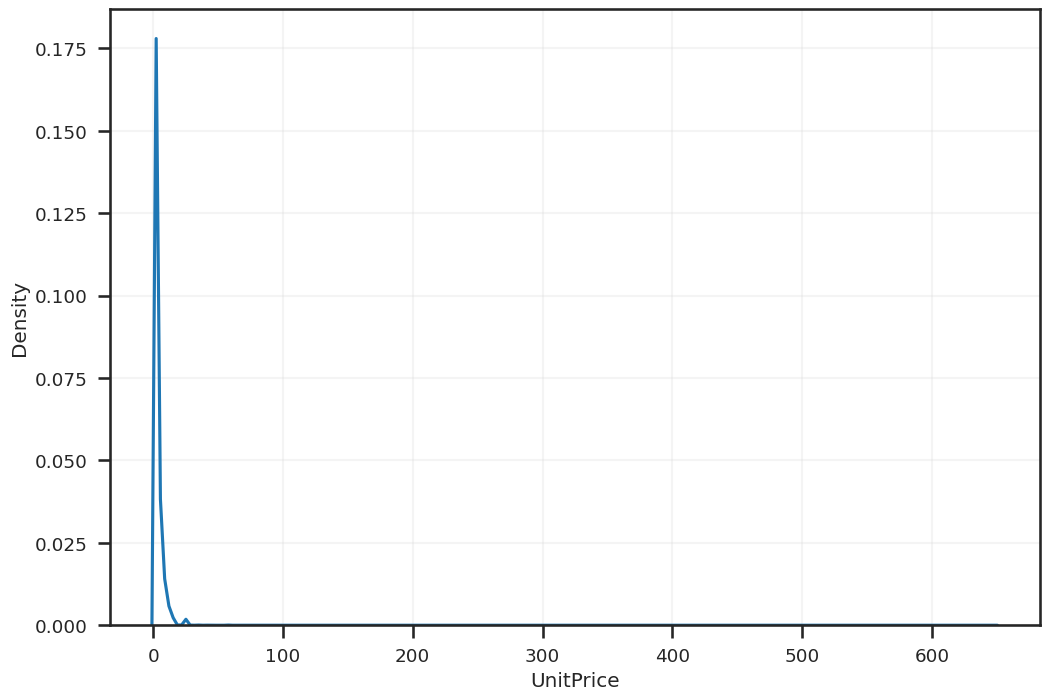

In [ ]:
# Agora que temos um dataset bem estruturado, podemos fazer análises gráficas mais tranquilamente.
# Começaremos fazendo as curvas de densidade de Quantity e UNitPrice e ver se elas tem algum comportamento interessante
# Começando com o UnitPrice

sns.kdeplot(df_filtered['UnitPrice'])
plt.show()

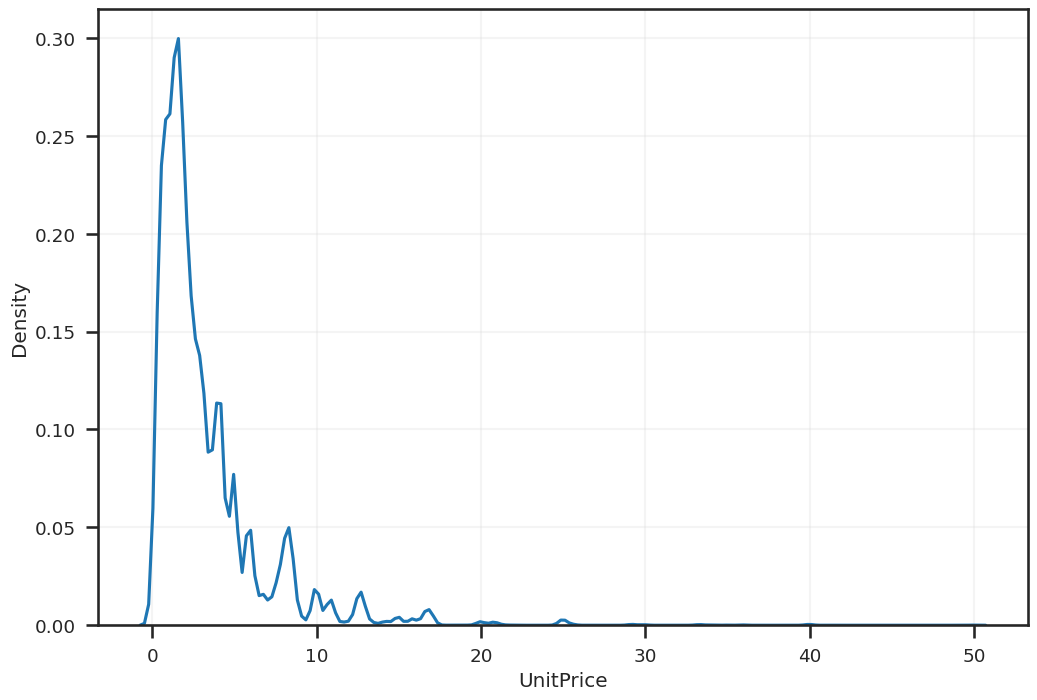

In [ ]:
# É perceptível notar que muitos itens tem baixo valor, portanto vamos plotar apenas os itens que custem menos de 50
sns.kdeplot(df_filtered[df_filtered['UnitPrice']<50]['UnitPrice'])
plt.show()

Dessa maneira, pudemos notar que a grande densidade de itens é de preços baixos.

Agora vamos repetir para a grandeza de Quantity

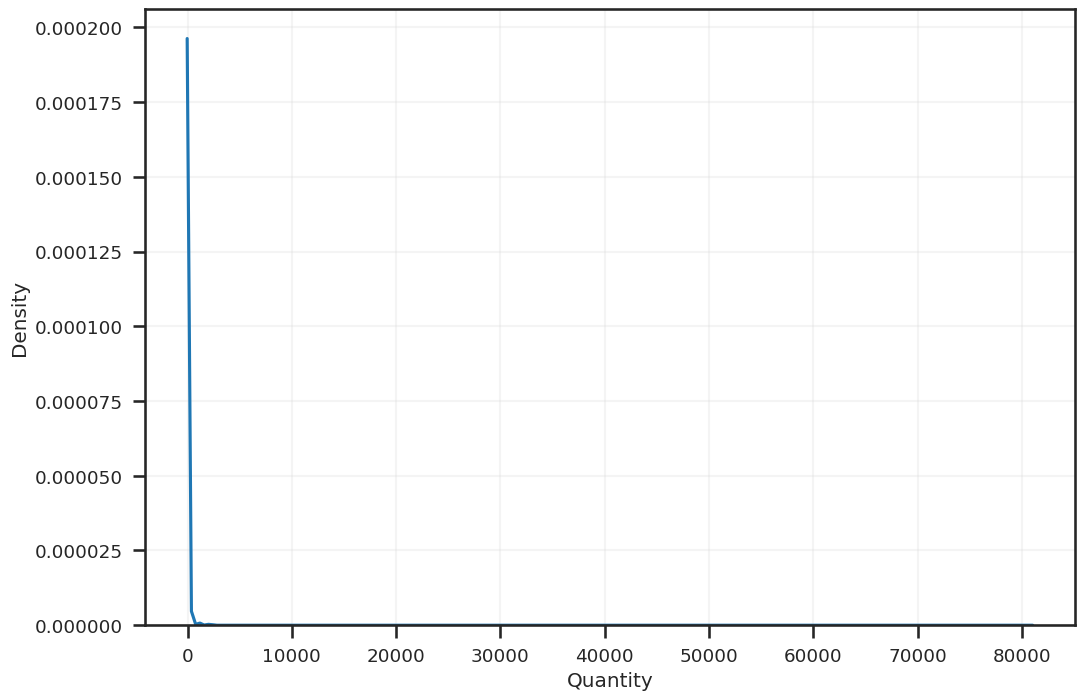

In [ ]:
sns.kdeplot(df_filtered['Quantity'])
plt.show()

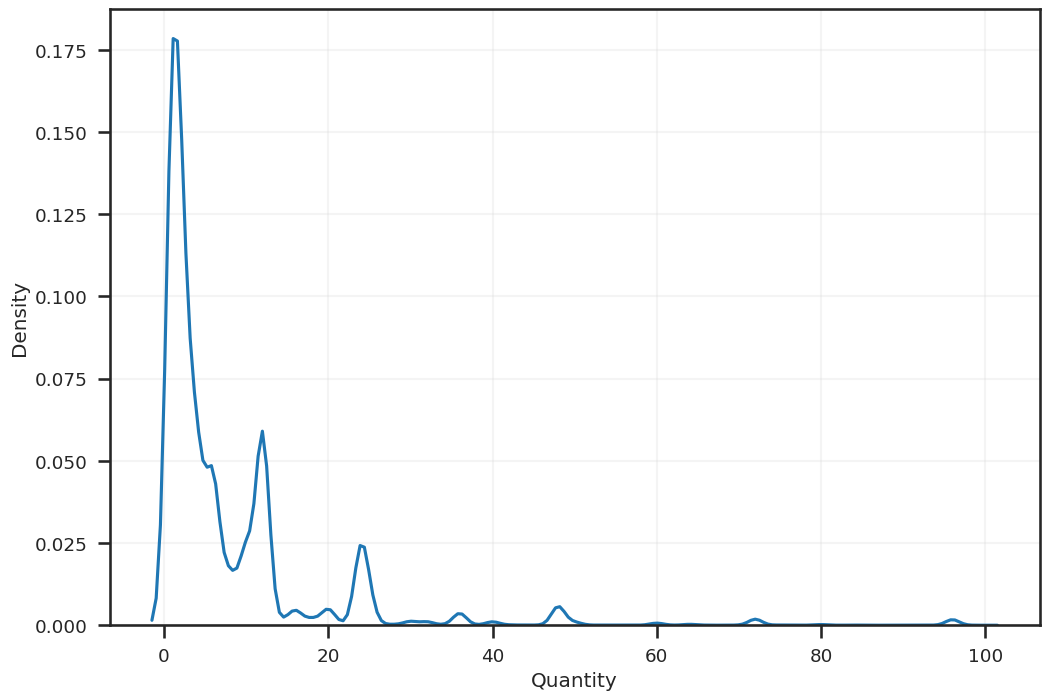

In [ ]:
# Novamente, vamos focar em um n° seleto de quantidades, para melhorar nossas visualizações
sns.kdeplot(df_filtered[df_filtered['Quantity']<100]['Quantity'])
plt.show()

Agora ficou claro perceber que a maior parte das vendas também é concentrada em pequenos volumes de itens

In [ ]:
df_filtered.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# 2. Data Preprocessing

Na etapa de pré-processamento vamos preparar nossos dados para os modelos de clusterização. Aqui faremos:
1. Normalização dos dados
2. Data Wrangling para criar as métricas de RFM

In [ ]:
# Antes de Normalizarmos nossos dados vamos criar as métricas RFM (Recency, Frequency, Monetary)

# Supondo que usaremos InvoiceDate como data das compras
# Calculando a recência (em dias) a partir da data mais recente
recent_date = df_filtered['InvoiceDate'].max()
df_filtered['Recency'] = (recent_date - df_filtered['InvoiceDate']).dt.days

In [ ]:
#Dessa forma, o DF fica da seguinte forma
df_filtered.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Recency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,373
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,373
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373


In [ ]:
# Agrupando por 'CustomerID' e calculando a frequência e o valor monetário
rfm_table = df_filtered.groupby('CustomerID').agg({
    'Recency': 'min',  # Usamos min para obter a recência mais recente
    'InvoiceNo': 'count',  # Contamos o número de compras para obter a frequência
    'UnitPrice': 'sum'  # Somamos os preços unitários para obter o valor monetário total
})

# Renomeando as colunas para Recency, Frequency e Monetary
rfm_table.rename(columns={
    'InvoiceNo': 'Frequency',
    'UnitPrice': 'Monetary'
}, inplace=True)

rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,1.04
12347.0,1,182,481.21
12348.0,74,27,18.71
12349.0,18,72,305.10
12350.0,309,16,25.30


In [ ]:
# Adicionando os valores RFM ao dataframe original
df_filtered_rfm = pd.merge(df_filtered, rfm_table, on='CustomerID')

# Exibindo o dataframe com as colunas RFM adicionadas
df_filtered_rfm.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Recency_x,Recency_y,Frequency,Monetary
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,373,371,297,1176.23
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373,371,297,1176.23
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,373,371,297,1176.23
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373,371,297,1176.23
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,373,371,297,1176.23
